In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import data
data = pd.read_csv(
    '../data/external/preprocessed.csv',
    dtype_backend='pyarrow',
)

In [4]:
data['date'] = pd.to_datetime(data['date'], unit='s')
data['score'] = data['score'].astype('int64[pyarrow]')
data.head()

,joke,body,punchline,score,date
0,A Day in Court,<NA>,A Day in Court,5,2008-01-25 17:32:47
1,Photograph of Software project Team,<NA>,Photograph of Software project Team,0,2008-02-10 11:28:57
2,what we guys really like,<NA>,what we guys really like,3,2008-02-10 13:42:54
3,The Nietzsche Family Circus random generator,<NA>,The Nietzsche Family Circus random generator,3,2008-02-29 01:35:58
4,funny pic: His & Hers SUV,<NA>,funny pic: His & Hers SUV,0,2008-03-21 19:47:05


In [5]:
# Check the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573408 entries, 0 to 573407
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype          
---  ------     --------------   -----          
 0   joke       573402 non-null  string[pyarrow]
 1   body       567641 non-null  string[pyarrow]
 2   punchline  573335 non-null  string[pyarrow]
 3   score      573335 non-null  int64[pyarrow] 
 4   date       573296 non-null  datetime64[ns] 
dtypes: datetime64[ns](1), int64[pyarrow](1), string[pyarrow](3)
memory usage: 279.5 MB


In [6]:
# Remve the rows with missing values
data = data.dropna()

In [7]:
# Check summary statistics
data.describe() 

,score,date
count,567565.0,567565
mean,220.298262,2017-04-06 18:38:36.766774784
min,0.0,2009-06-29 01:46:21
25%,1.0,2016-01-29 18:55:45
50%,5.0,2017-05-31 16:32:55
75%,20.0,2018-10-28 04:08:04
max,136353.0,2019-12-31 23:58:52
std,2040.292032,NaN


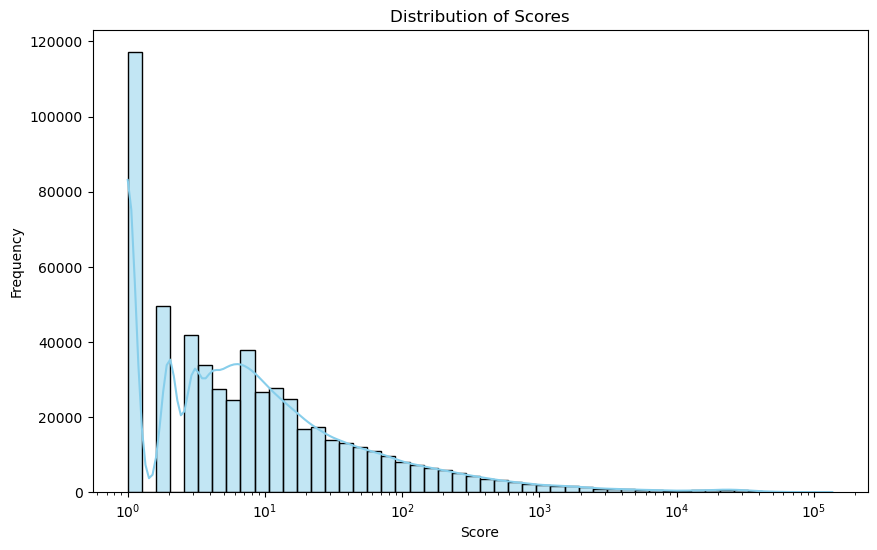

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot((data['score']+1), bins=50, color='skyblue', kde=True, log_scale=True) # Log +1 transformation
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

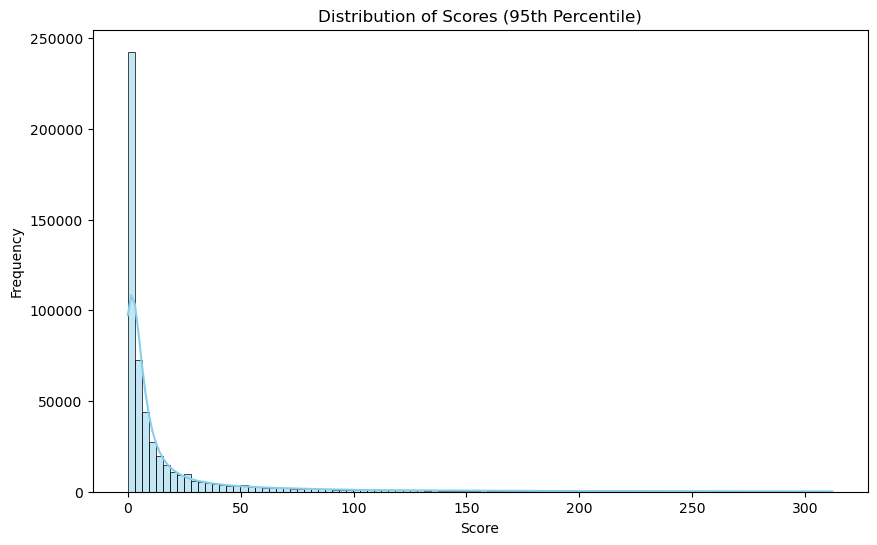

In [9]:
# Plot the distribution of scores (95th percentile)
# Calculate the 95th percentile limit
limit = data['score'].quantile(0.95)

# Create a subset of your data up to the 95th percentile
data_95 = data[data['score'] <= limit]

# Plot the distribution of scores (95th percentile)
plt.figure(figsize=(10, 6))
sns.histplot(data_95['score'], bins=100, color='skyblue', kde=True)
plt.title('Distribution of Scores (95th Percentile)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [29]:
import re
import string
from joblib import Parallel, delayed

# List of offensive words to filter out
offensive_words = [
    "nigger", "kike", "faggot", "retard", "sperg",
    "tranny", "trannie", "shemale", "shim", "sodomite"
]

def preprocess_jokes(df, joke_column='joke', llm=False):
    """
    Preprocess the jokes in a DataFrame for simple machine learning models.
    
    Args:
        df (pd.DataFrame): DataFrame containing the jokes.
        joke_column (str): The column name containing the jokes.
        
    Returns:
        pd.DataFrame: DataFrame with an additional 'cleaned_joke' column.
        int: Count of offensive jokes removed.
        int: Count of jokes removed due to insufficient length.
    """
    
    def clean_joke(joke):
        """
        Clean an individual joke.
        
        Args:
            joke (str): The joke to clean.
            
        Returns:
            str: Cleaned joke.
        """
        # Lowercase the joke
        joke = joke.lower()
        
        # Remove URLs and non-joke content
        joke = re.sub(r'http\S+', '', joke)  # Remove URLs
        joke = re.sub(r'\s+', ' ', joke).strip()  # Remove excessive whitespace and trim
        
        # Remove special characters and digits
        joke = joke.translate(str.maketrans('', '', string.punctuation + string.digits))
        
        return joke
    
    def is_offensive(joke):
            """
            Check if the joke contains any offensive words.
            
            Args:
                joke (str): The joke to check.
                
            Returns:
                bool: True if the joke contains offensive words, False otherwise.
            """
            return any(word in joke for word in offensive_words)
        
    offensive_count = 0
    length_count = 0
    
    def process_row(joke):
        nonlocal offensive_count, length_count
        
        if not isinstance(joke, str):
            return None
        
        cleaned = clean_joke(joke)
        
        if is_offensive(cleaned):
            offensive_count += 1
            return None
        
        if len(cleaned) <= 10:
            length_count += 1
            return None
        
        return cleaned
    
    # Skip lower case and clean jokes for LLM
    def process_row_llm(joke):
        nonlocal offensive_count, length_count
        
        if not isinstance(joke, str):
            return None
        
        if is_offensive(joke):
            offensive_count += 1
            return None
        
        if len(joke) <= 10:
            length_count += 1
            return None
        
        return joke
    
    if llm:
        df['cleaned_joke'] = Parallel(n_jobs=-1)(delayed(process_row_llm)(row) for row in df[joke_column])
    else:
        df['cleaned_joke'] = Parallel(n_jobs=-1)(delayed(process_row)(row) for row in df[joke_column])
    
    duplicate_count = df.duplicated(subset=['cleaned_joke']).sum()
    
    df = df.drop_duplicates(subset=['cleaned_joke'])

    # Drop rows with None in 'cleaned_joke' column
    df = df.dropna(subset=['cleaned_joke'])
    
    return df, offensive_count, length_count, duplicate_count

In [30]:
cleaned_jokes, offensive_count, length_count, duplicate_count = preprocess_jokes(data, 'joke', llm=True)

In [31]:
print(f"Cleaned Jokes: {len(cleaned_jokes)}")
print(f"Offensive Jokes Removed: {offensive_count}")
print(f"Jokes Removed Due to Length: {length_count}")
print(f"Duplicate Jokes Removed: {duplicate_count}")

Cleaned Jokes: 554199
Offensive Jokes Removed: 0
Jokes Removed Due to Length: 0
Duplicate Jokes Removed: 13365


In [32]:
cleaned_jokes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 554199 entries, 178 to 573407
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype          
---  ------        --------------   -----          
 0   joke          554199 non-null  string[pyarrow]
 1   body          554199 non-null  string[pyarrow]
 2   punchline     554199 non-null  string[pyarrow]
 3   score         554199 non-null  int64[pyarrow] 
 4   date          554199 non-null  datetime64[ns] 
 5   cleaned_joke  554199 non-null  object         
dtypes: datetime64[ns](1), int64[pyarrow](1), object(1), string[pyarrow](3)
memory usage: 282.4+ MB


In [33]:
# replace NA scores with 0
cleaned_jokes['score'] = cleaned_jokes['score'].astype('Int64[pyarrow]')
cleaned_jokes['score'] = cleaned_jokes['score'].fillna(0)

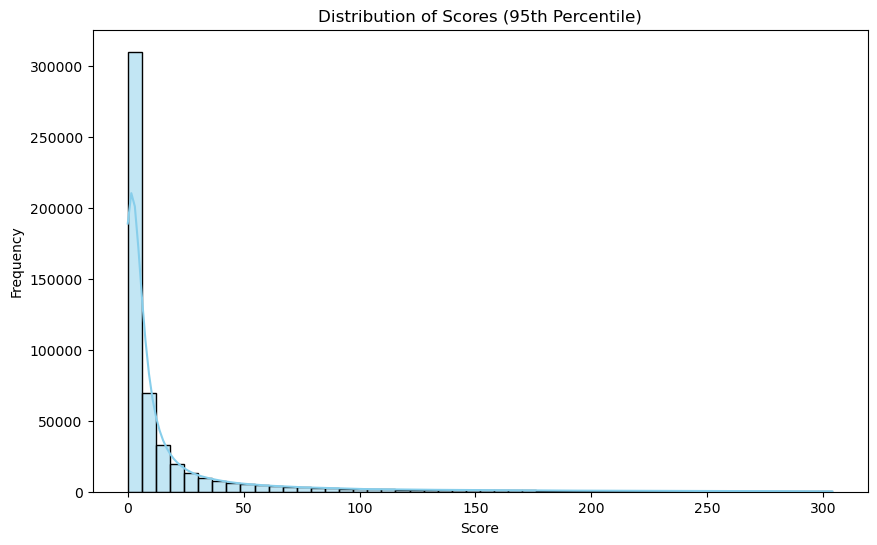

In [34]:
limit = cleaned_jokes['score'].quantile(0.95)

data_95 = cleaned_jokes[cleaned_jokes['score'] <= limit]

# Plot the distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot((data_95['score']), bins=50, color='skyblue', kde=True)
plt.title('Distribution of Scores (95th Percentile)')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [35]:
# Count the number of words in each joke
from nltk.tokenize import word_tokenize
from joblib import Parallel, delayed

# Apply function in parallel
cleaned_jokes['tokenized_joke'] = Parallel(n_jobs=-1)(delayed(word_tokenize)(joke) for joke in cleaned_jokes['cleaned_joke'])

# Calculate the number of words in each joke
cleaned_jokes['num_words'] = cleaned_jokes['tokenized_joke'].apply(len)

# Get 95 percentile of the number of words
limit = cleaned_jokes['num_words'].quantile(0.95)

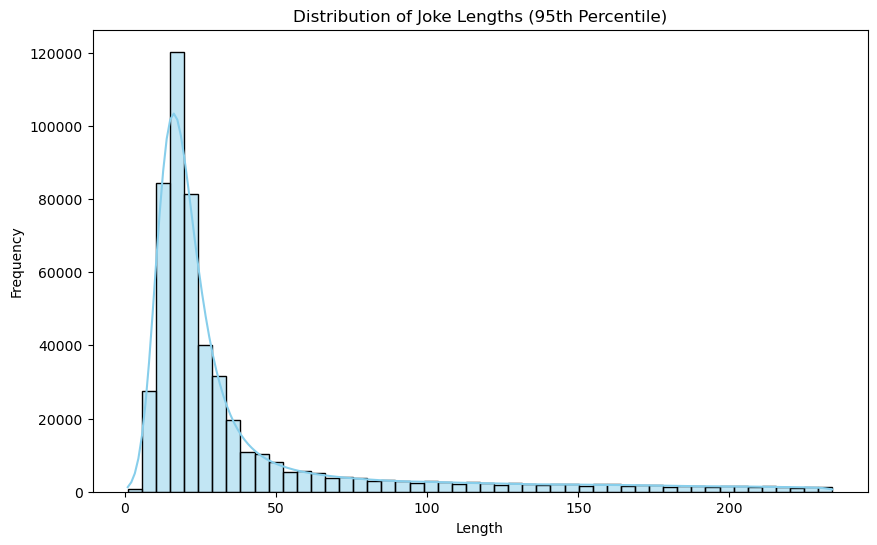

In [36]:
# Plot the distribution of joke lengths
downsample_data_95 = cleaned_jokes[cleaned_jokes['num_words'] <= limit]

plt.figure(figsize=(10, 6))
sns.histplot(downsample_data_95['num_words'], bins=50, color='skyblue', kde=True)
plt.title('Distribution of Joke Lengths (95th Percentile)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()


In [37]:
def filter_below_quantile(df, column, quantile=0.95):
    original_count = len(df)
    filtered_df = df[df[column] <= df[column].quantile(quantile)]
    removed_count = original_count - len(filtered_df)
    print(f"Removed {removed_count} rows based on {column}")
    return filtered_df

cleaned_jokes = filter_below_quantile(cleaned_jokes, 'score')
cleaned_jokes = filter_below_quantile(cleaned_jokes, 'num_words')

Removed 27677 rows based on score
Removed 26191 rows based on num_words


In [38]:
# make five classes of scores based on quantiles
labels = [1, 2, 3, 4, 5]
cleaned_jokes['score_class'] = pd.qcut(cleaned_jokes['score'], 6, duplicates='drop', labels=labels)

cleaned_jokes['score_class'].value_counts()


score_class
1    199810
3     83385
5     82344
4     76711
2     58081
Name: count, dtype: int64

In [39]:
# Import from imblearn
from imblearn.under_sampling import RandomUnderSampler

def undersampling(df, target_column, sample_strategy='auto'):
    """
    undersampling the dataset to balance the distribution of the target column.
    
    Args:
        df (pd.DataFrame): The input dataframe.
        target_column (str): The column to balance.
        sample_strategy (str): The sampling strategy to use.
        
    Returns:
        pd.DataFrame: The downsampled dataframe.
    """
    # Create the undersampler
    undersampler = RandomUnderSampler(sampling_strategy=sample_strategy, random_state=42)

    # Separate the features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Fit the data to the undersampler
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # Combine the features and target
    df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

    return df_resampled

In [40]:
cleaned_jokes = undersampling(cleaned_jokes, 'score_class', sample_strategy='majority')

In [41]:
cleaned_jokes['score_class'].value_counts()

score_class
3    83385
5    82344
4    76711
1    58081
2    58081
Name: count, dtype: int64

In [28]:
cleaned_jokes.to_parquet('../data/interim/cleaned_jokes.parquet', index=False)

In [42]:
# Clean for use in Pretraining
pretraining_data = cleaned_jokes[['cleaned_joke', 'score_class']]
pretraining_data.to_parquet('../data/processed/pretraining_data.parquet', index=False)

In [43]:
pretraining_data = pd.read_parquet('../data/processed/pretraining_data.parquet')

In [44]:
pretraining_data.head()

,cleaned_joke,score_class
0,Me: I am just feeling so light Man. Feels like...,1
1,TIFU by firing a torpedo at an ally submarine ...,1
2,music joke As the Cellist in our string quarte...,1
3,"What kind of overalls does mario wear? Denim, ...",1
4,The last thing you want on a flight is to be w...,1


In [45]:
# Print a joke from each class
labels = [1, 2, 3, 4, 5]
for label in labels:
    print(f"Class {label}: {pretraining_data[pretraining_data['score_class'] == label].iloc[0]['cleaned_joke']}")

Class 1: Me: I am just feeling so light Man. Feels like i can fly over the horizon and vanish in to the unknown. Friend: You must be relieved that i got out of prison. Me: Also that but i just took a massive Shit.
Class 2: Here's a joke just for reddit: How many narwhals does it take to screw in a light bulb? Bacon
Class 3: I hope you're all getting your Walter Cronkite jokes in order. He's next.  Here's mine.   Ed McMahon, David Carradine, Farrah Fawcett, Michael Jackson, Billy Mays, and Walter Cronkite walk into a bar.   And die.   Your turn. 
Class 4: What is the only thing a woman can say that will make a man feel both happy and sad at the same time?  "Your dick is bigger than your brother's." 
Class 5: Why is gambling not allowed in Africa? Because there are too many cheetahs.


: 